In [4]:
import numpy as np
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt
import utils
import imutils
from sklearn.preprocessing import RobustScaler
%matplotlib inline

In [5]:
def outlierReject(lines):
    first = []
    for line in lines:
        first.append(line[0])
        
    first = np.array(first)
    center = np.mean(first, axis=0)
    
    dists = np.zeros(len(first))
    for i in range(len(first)):
        dists[i] = np.linalg.norm(first[i] - center)
        
    m = np.mean(dists)
    std = np.std(dists)
    
    rejected = []
    for i in range(len(dists)):
        if np.abs(dists[i] - m) > 3*std:
            pass
        else:
            rejected.append(first[i])
    
    rejected = np.array(rejected)

    return rejected

In [6]:
def calDiff(vgws_first, wires_first):
    vgws_m = np.mean(vgws_first, axis=0)
    wires_m = np.mean(wires_first, axis=0)
    
    diff = wires_m - vgws_m
    
    return diff.astype(np.int)

In [7]:
def drawIntegrated(p, s, root='./', save='Translated'):
    db_path = os.path.join(root, 'setting.pkl')
    db = utils.DataLoading(db_path, save)
    
    gw_label_path = os.path.join(root, 'gw_labels')
    ps = '%02d/%s' % (p, s)
    gw_label_path = os.path.join(gw_label_path, ps)
    
    angio_folder = os.path.join('../Data', '{0:02d}'.format(p))
    angio_folder = os.path.join(angio_folder, s)
    angio_overlay = utils.makeAngioOverlay(angio_folder)
    
    vgws, vgws_mean = utils.loadFirstPoint(p, s, returnAll=True)
    vgws_new = outlierReject(vgws)

    wires = utils.returnGuidewireNew(gw_label_path, vgws_mean, tipOnly=False)
    wires_new = outlierReject(wires)
    angio_gw = utils.drawWireInit(angio_overlay, wires, color=(0,0,255), circle=2)
    angio_gw = utils.drawWireInit(angio_gw, wires_new, color=(0,255,0), circle=3, th=1, isFirst=True)
                
        
    angio_gw_vgw = utils.drawWireInit(angio_gw, vgws, color=(255,0,0), circle=2, th=-1)
    angio_gw_vgw = utils.drawWireInit(angio_gw_vgw, vgws_new, color=(255,255,0), circle=3, th=1, isFirst=True)
    
    return angio_gw_vgw

In [8]:
def drawTranslated(p, s, root='./', save='Translated'):
    db_path = os.path.join(root, 'setting.pkl')
    db = utils.DataLoading(db_path, save)
    
    gw_label_path = os.path.join(root, 'gw_labels')
    ps = '%02d/%s' % (p, s)
    gw_label_path = os.path.join(gw_label_path, ps)
    
    angio_folder = os.path.join('../Data', '{0:02d}'.format(p))
    angio_folder = os.path.join(angio_folder, s)
    angio_overlay = utils.makeAngioOverlay(angio_folder)
    
    vgws, vgws_mean = utils.loadFirstPoint(p, s, returnAll=True)
    vgws_new = outlierReject(vgws)

    wires = utils.returnGuidewireNew(gw_label_path, vgws_mean, tipOnly=False)
    wires_new = outlierReject(wires)
    
    diff = calDiff(vgws_new, wires_new)

    angio_gw = utils.drawWireInit(angio_overlay, wires, color=(0,0,255), circle=2)
    angio_gw = utils.drawWireInit(angio_gw, wires, color=(0,255,0), circle=3, th=1, trans=diff)
                 
    angio_gw_vgw = utils.drawWireInit(angio_gw, vgws, color=(255,0,0), circle=2, th=-1)
    
    return angio_gw_vgw

In [50]:
def translationSave(root='../Data', db_path='setting.pkl'):
    db = utils.DataLoading(db_path, 'Translated')
    for p in db.database.keys():
        try:
            for s in db.database[p].keys():
                ps = '%02d/%s' % (p, s)
                fluoro_folder = os.path.join(root, ps)
                fluoro_dirs = glob(os.path.join(fluoro_folder, 'fluoro/*.png'))
                fluoro_dirs.sort()
                
                gw_label_path = os.path.join('./gw_labels', ps)
                
                vgws, vgws_mean = utils.loadFirstPoint(p, s, returnAll=True)
                vgws_new = outlierReject(vgws)
                wires = utils.returnGuidewireNew(gw_label_path, vgws_mean, tipOnly=False)
                wires_new = outlierReject(wires)
                diff = calDiff(vgws_new, wires_new)
                
                print('Start Data', ps)
                
                for i in range(len(fluoro_dirs)):
                    if i % 10 == 0:
                        print('Progressing', ps, i, '/', len(fluoro_dirs))
                    f_path = fluoro_dirs[i]
                    img = cv2.imread(f_path, cv2.IMREAD_GRAYSCALE)
                    rows = img.shape[0]
                    cols = img.shape[1]
                    M = np.array([[1 , 0, -diff[0]], [0, 1, -diff[1]]], dtype=np.float32)
                    new_img = cv2.warpAffine(img, M, (cols, rows), borderValue=255)
                    f_save = f_path.replace('fluoro', 'fluoroTrans')
                    f_save_folder = os.path.split(f_save)[0]
                    if not os.path.exists(f_save_folder):
                        os.makedirs(f_save_folder)
                    cv2.imwrite(f_save, new_img)
                    
                    ft_path = f_path.replace('fluoro', 'fluoroTip')
                    img = cv2.imread(ft_path, cv2.IMREAD_GRAYSCALE)
                    rows = img.shape[0]
                    cols = img.shape[1]
                    M = np.array([[1 , 0, -diff[0]], [0, 1, -diff[1]]], dtype=np.float32)
                    new_img = cv2.warpAffine(img, M, (cols, rows), borderValue=255)
                    ft_save = ft_path.replace('fluoroTip', 'fluoroTipTrans')
                    ft_save_folder = os.path.split(ft_save)[0]
                    if not os.path.exists(ft_save_folder):
                        os.makedirs(ft_save_folder)
                    cv2.imwrite(ft_save, new_img)
                    
                print('Done', ps)

        
        except AttributeError:
            pass

In [51]:
translationSave('../Data')

Start Data 01/set01
Progressing 01/set01 0 / 130
Progressing 01/set01 10 / 130
Progressing 01/set01 20 / 130
Progressing 01/set01 30 / 130
Progressing 01/set01 40 / 130
Progressing 01/set01 50 / 130
Progressing 01/set01 60 / 130
Progressing 01/set01 70 / 130
Progressing 01/set01 80 / 130
Progressing 01/set01 90 / 130
Progressing 01/set01 100 / 130
Progressing 01/set01 110 / 130
Progressing 01/set01 120 / 130
Done 01/set01
Start Data 02/set01
Progressing 02/set01 0 / 43
Progressing 02/set01 10 / 43
Progressing 02/set01 20 / 43
Progressing 02/set01 30 / 43
Progressing 02/set01 40 / 43
Done 02/set01
Start Data 03/set03
Progressing 03/set03 0 / 66
Progressing 03/set03 10 / 66
Progressing 03/set03 20 / 66
Progressing 03/set03 30 / 66
Progressing 03/set03 40 / 66
Progressing 03/set03 50 / 66
Progressing 03/set03 60 / 66
Done 03/set03
Start Data 05/set01
Progressing 05/set01 0 / 300
Progressing 05/set01 10 / 300
Progressing 05/set01 20 / 300
Progressing 05/set01 30 / 300
Progressing 05/set01 

In [52]:
translationSave('/docker/img2img_registration/Data')

Start Data 01/set01
Progressing 01/set01 0 / 130
Progressing 01/set01 10 / 130
Progressing 01/set01 20 / 130
Progressing 01/set01 30 / 130
Progressing 01/set01 40 / 130
Progressing 01/set01 50 / 130
Progressing 01/set01 60 / 130
Progressing 01/set01 70 / 130
Progressing 01/set01 80 / 130
Progressing 01/set01 90 / 130
Progressing 01/set01 100 / 130
Progressing 01/set01 110 / 130
Progressing 01/set01 120 / 130
Done 01/set01
Start Data 02/set01
Progressing 02/set01 0 / 43
Progressing 02/set01 10 / 43
Progressing 02/set01 20 / 43
Progressing 02/set01 30 / 43
Progressing 02/set01 40 / 43
Done 02/set01
Start Data 03/set03
Progressing 03/set03 0 / 66
Progressing 03/set03 10 / 66
Progressing 03/set03 20 / 66
Progressing 03/set03 30 / 66
Progressing 03/set03 40 / 66
Progressing 03/set03 50 / 66
Progressing 03/set03 60 / 66
Done 03/set03
Start Data 05/set01
Progressing 05/set01 0 / 300
Progressing 05/set01 10 / 300
Progressing 05/set01 20 / 300
Progressing 05/set01 30 / 300
Progressing 05/set01 

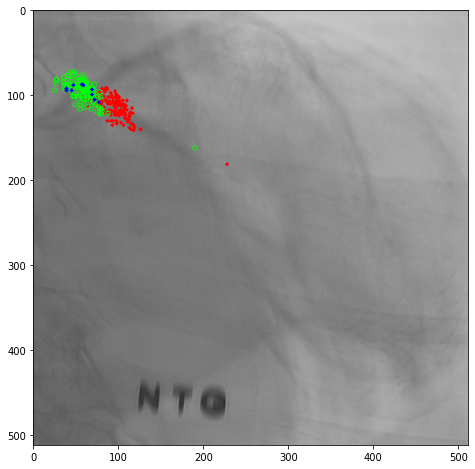

In [21]:
test = drawTranslated(1, 'set01')
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
db = utils.DataLoading('setting.pkl', 'Translated')

In [ ]:
for p in db.database.keys():
    try:
        for s in db.database[p].keys():
            test = drawTranslated(p, s)
            plt.figure(figsize=(8,8))
            plt.imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))
            plt.show()
    except AttributeError:
        pass